In [98]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import vk_api
import csv
import scipy
from networkx.algorithms.community import k_clique_communities, greedy_modularity_communities, modularity 
from networkx.algorithms.community import kernighan_lin, _naive_greedy_modularity_communities

# Getting the data

In [63]:
# two factor authentication to VK using api
def enter_code():
    code = input('code: ')
    return code, True

vk_session = vk_api.VkApi(login = '', password = '', auth_handler = enter_code)
vk_session.auth()
vk = vk_session.get_api()

In [65]:
# getting the list of my friends with their names
friends = vk.friends.get(user_id = 75686614, order = 'hits', fields = 'nickname')

In [66]:
# matching ids to names
ids = [friend['id'] for friend in friends['items']]
ids_to_names = {friend['id']: friend['first_name'] + ' ' + friend['last_name'] for friend in friends['items']}

In [67]:
# writing all edges of the future graph to the file: if id1 from the list of friends is also a friend of id2, then
# the edge id1-id2 is saves
file = open('network.txt', 'w')
failed_users = []
for id in ids:
    k = 0
    try:
        f = vk.friends.get(user_id = id)
    except:
        failed_users.append(id)
    potential_edges = f['items']
    for edge in potential_edges:
        if edge in ids:
            k += 1
            file.write(str(id) + ' ' + str(edge) + '\n')
    if k == 0:
       file.write(str(id) + ' ' + str(id) + '\n') 
file.close()

In [68]:
# the table matching ids to names is saved
df = pd.DataFrame.from_dict(ids_to_names, orient = 'index', columns = ['Name'])
df = df.reset_index()
df = df.rename(columns = {'index': 'id'})

# Network Summary

In [2]:
# the file with mapping of ids to names is read as dictionary
mapping = pd.read_csv('ids_to_names.csv', dtype = str)
mapping = mapping.set_index('id')
mapping = mapping.to_dict()['Name']

In [3]:
# the graph is created from the list of edges, names of nodes are changes to people's name
g = nx.read_edgelist('network.txt')
g = nx.relabel_nodes(g, mapping)
g.remove_node('DELETED ') # a person whose page has been deleted is dropped

In [4]:
# calculating size and order of the network
g.size(), g.number_of_nodes()

(2554, 174)

In [5]:
# saving the giant component as a saparate graph
giant_cc = nx.subgraph(g, max(nx.connected_components(g), key = len))

In [6]:
# calculating diameter and radium of the giant component 
nx.diameter(giant_cc), nx.radius(giant_cc)

(6, 4)

In [7]:
# calculating global and avg local clustering coefficients
def global_clustering(g):
    return sum(nx.triangles(g).values()) / sum(nx.triangles(nx.complete_graph(g.number_of_nodes())).values())

global_clustering(g), nx.average_clustering(g)

(0.030584385183399697, 0.642238946166609)

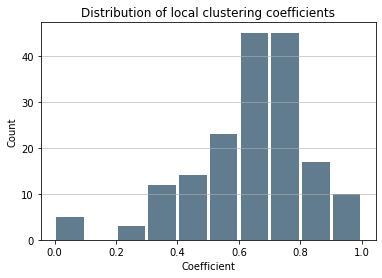

In [8]:
# drawing the histogram of local clustering coefficients
s = pd.Series(nx.clustering(g))
s.plot.hist(grid = False, rwidth=0.9, color='#607c8e')
plt.title('Distribution of local clustering coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Count')
plt.grid(axis = 'y', alpha = 0.75)
plt.savefig('clustering.png', dpi = 300)

In [9]:
# calculating avg path length
nx.average_shortest_path_length(giant_cc)

2.6880184958520332

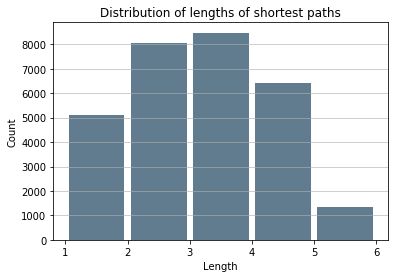

In [23]:
# drawing the histogram of path lengths
paths = dict(nx.shortest_path_length(giant_cc))
paths = [value for (key, value) in paths.items()]
path_lengths = []
for n in paths:
    for k, v in n.items():
        if v != 0:
            path_lengths.append(v)
            
s = pd.Series(path_lengths)

s.plot.hist(grid = False, bins = 5, rwidth=0.9, color='#607c8e')
plt.title('Distribution of lengths of shortest paths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.grid(axis = 'y', alpha = 0.75)
plt.savefig('paths.png', dpi = 300)

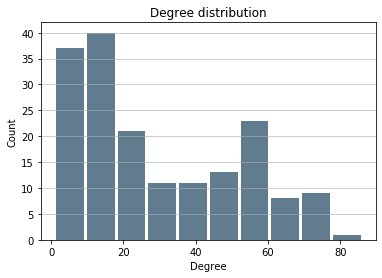

In [59]:
# drawing the network degree distribution
s = pd.Series([d for n, d in g.degree()])
s.plot.hist(grid = False, rwidth=0.9, color='#607c8e')
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.grid(axis = 'y', alpha = 0.75)
plt.savefig('dist.png', dpi = 300)

C:\Users\mspya\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


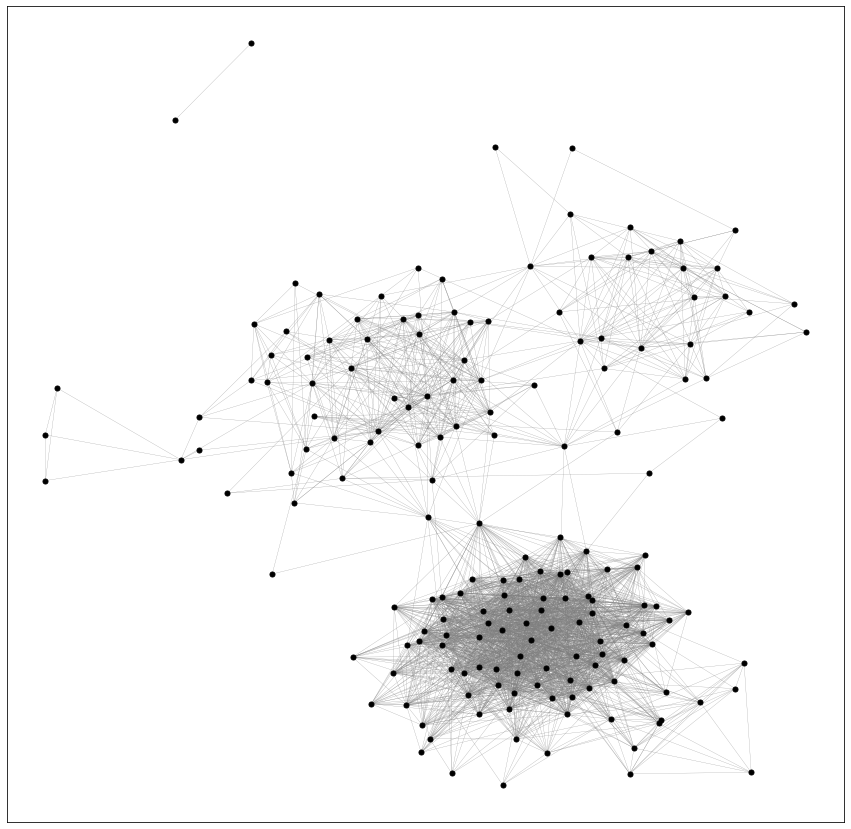

In [12]:
# drawing the full network
layout = nx.nx_pydot.graphviz_layout(g)
plt.figure(figsize = (15, 15))
nx.draw_networkx(g, pos = layout, node_size = 25, width = 0.2, node_color = 'k', 
                 edge_color = 'tab:gray', with_labels = False, font_size = 6)
plt.savefig('network.png', dpi = 300)

# Structural Analysis

In [13]:
# calculating degree, closeness and betweenness centralities for each node
degree = pd.DataFrame.from_dict(nx.degree_centrality(g), orient = 'index', columns = ['degree'])
closeness = pd.DataFrame.from_dict(nx.closeness_centrality(g), orient = 'index', columns = ['closeness'])
betweenness = pd.DataFrame.from_dict(nx.betweenness_centrality(g), orient = 'index', columns = ['betweenness'])
centralities = degree.join([closeness, betweenness])

In [60]:
def draw_network_with_top_nodes(g, top_nodes, file_name):
    """
    the function draws the network highlighting certain nodes passed as input
    """
    labels = {l: l for l in top_nodes}
    plt.figure(figsize = (15, 15))
    nx.draw_networkx(g, pos = layout, node_size = 25, width = 0.2, node_color = 'tab:gray', 
                     edge_color = 'tab:gray', with_labels = False, font_size = 6, alpha = 0.5)
    nx.draw_networkx_nodes(g, pos = layout, nodelist = list(top_nodes), node_size = 25, node_color = 'k')
    nx.draw_networkx_labels(g, pos = layout, font_size = 10, labels = labels, verticalalignment = 'bottom')
    plt.savefig(file_name, dpi = 300)

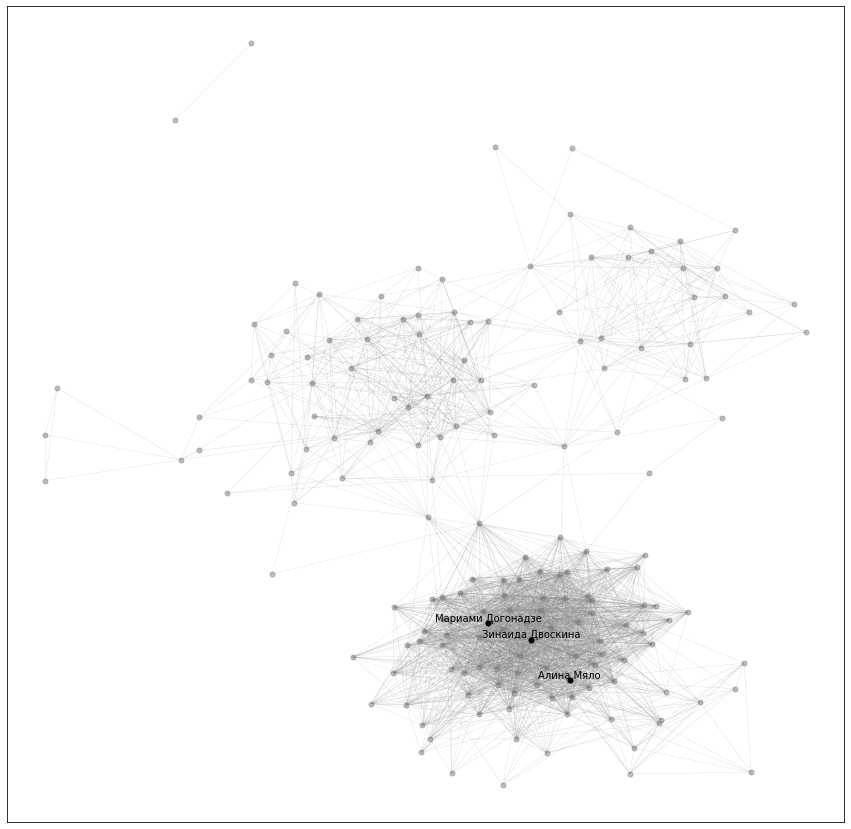

In [61]:
draw_network_with_top_nodes(g, centralities.sort_values('degree', ascending = False).head(3).index, 'degree.png')

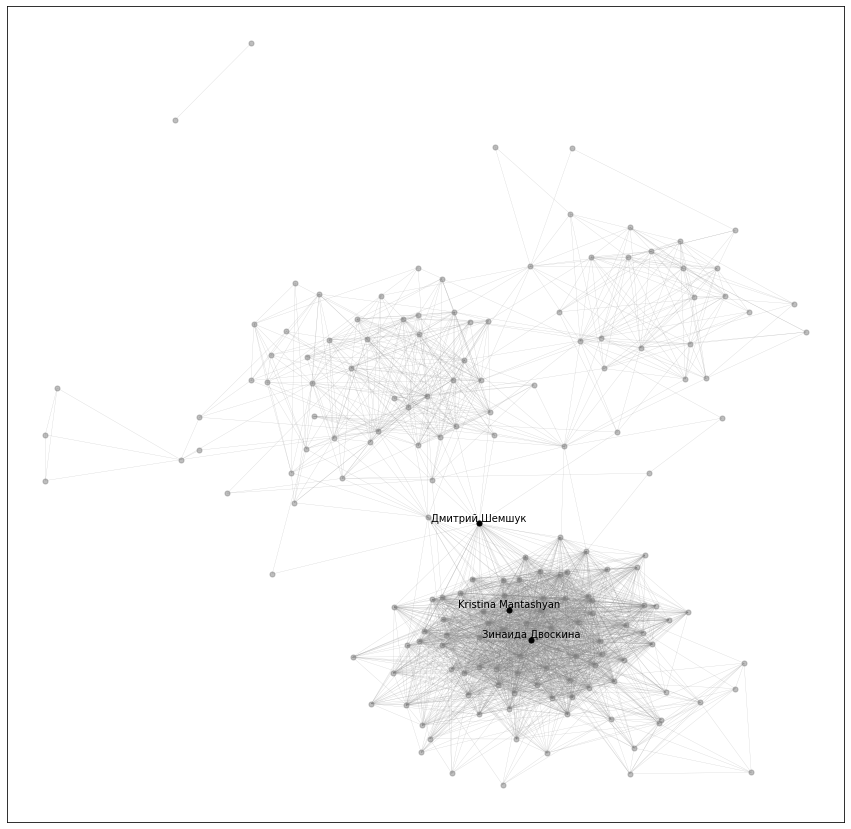

In [62]:
draw_network_with_top_nodes(g, centralities.sort_values('closeness', ascending = False).head(3).index, 
                            'closeness.png')

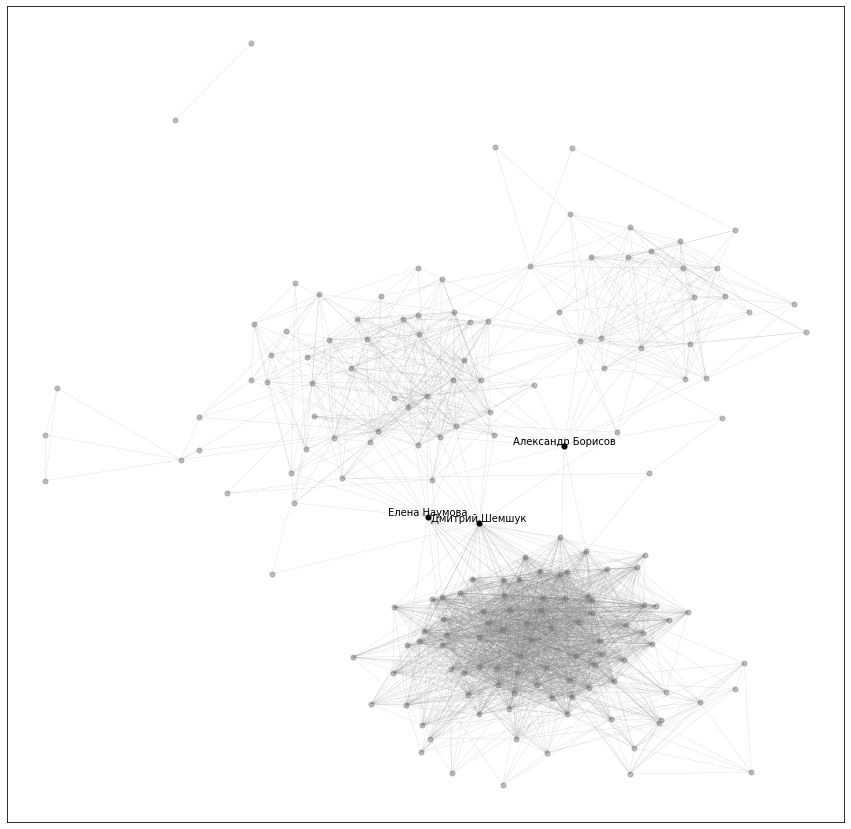

In [63]:
draw_network_with_top_nodes(g, centralities.sort_values('betweenness', ascending = False).head(3).index, 
                            'betweenness.png')

# Community Detection

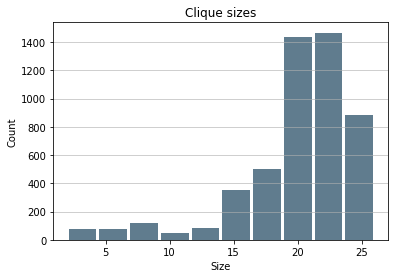

In [29]:
# drawing the histogram of clique sizes
cliques = list(nx.find_cliques(g))
cliques_sizes = [len(c) for c in cliques]

s = pd.Series(cliques_sizes)
s.plot.hist(grid = False, bins = 10, rwidth=0.9, color='#607c8e')
plt.title('Clique sizes')
plt.xlabel('Size')
plt.ylabel('Count')
plt.grid(axis = 'y', alpha = 0.75)
plt.savefig('clique.png', dpi = 300)

In [26]:
# calculation the size and the number of maximal clique
cliques_sizes = np.array(cliques_sizes)
max_clique_size = max(cliques_sizes)
unique, counts = np.unique(cliques_sizes, return_counts = True)
max_clique_count = dict(zip(unique, counts))[max_clique_size]
max_clique_size, max_clique_count

(26, 40)

In [32]:
def draw_k_core(g, k, file_name):
    """
    the function draws k-core visualization of the network
    """
    g.remove_edges_from(nx.selfloop_edges(g))
    k_core_network = nx.k_core(g, k)
    layout = nx.nx_pydot.graphviz_layout(k_core_network)
    plt.figure(figsize = (10, 10))
    nx.draw_networkx(k_core_network, pos = layout, node_size = 25, width = 0.2, node_color = 'k', 
                     edge_color = 'tab:gray', with_labels = False, font_size = 8)
    plt.savefig(file_name, dpi = 300)

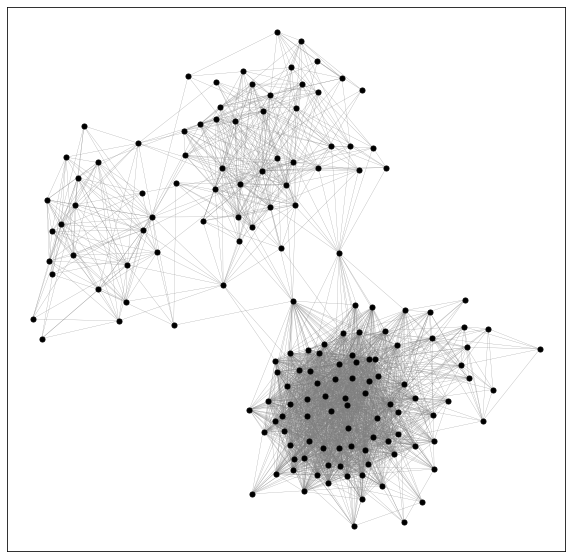

In [33]:
draw_k_core(g, 5, '5_core.png')

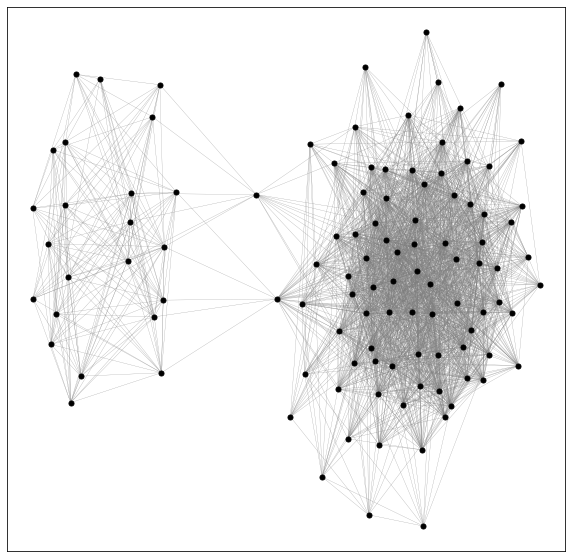

In [34]:
draw_k_core(g, 10, '10_core.png')

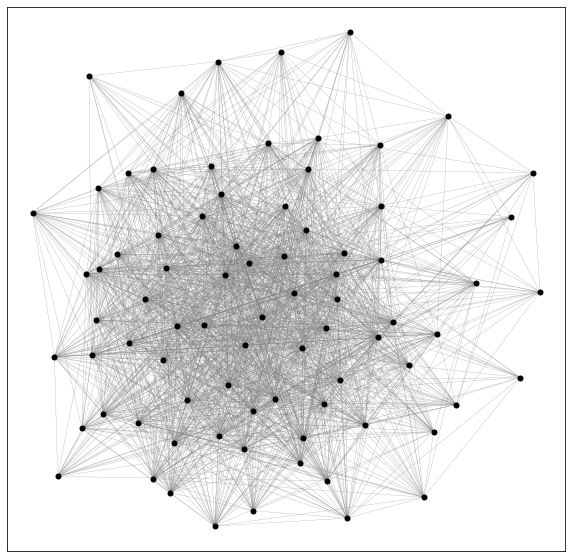

In [35]:
draw_k_core(g, 15, '15_core.png')

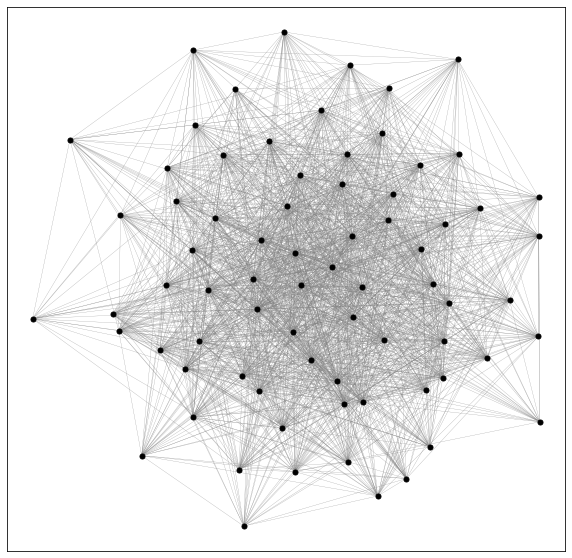

In [36]:
draw_k_core(g, 20, '20_core.png')

In [78]:
modularity(g, kernighan_lin.kernighan_lin_bisection(g))

0.31082247117090606

In [42]:
modularity(g, greedy_modularity_communities(g))

0.3122734188743483

In [103]:
comm = greedy_modularity_communities(g)

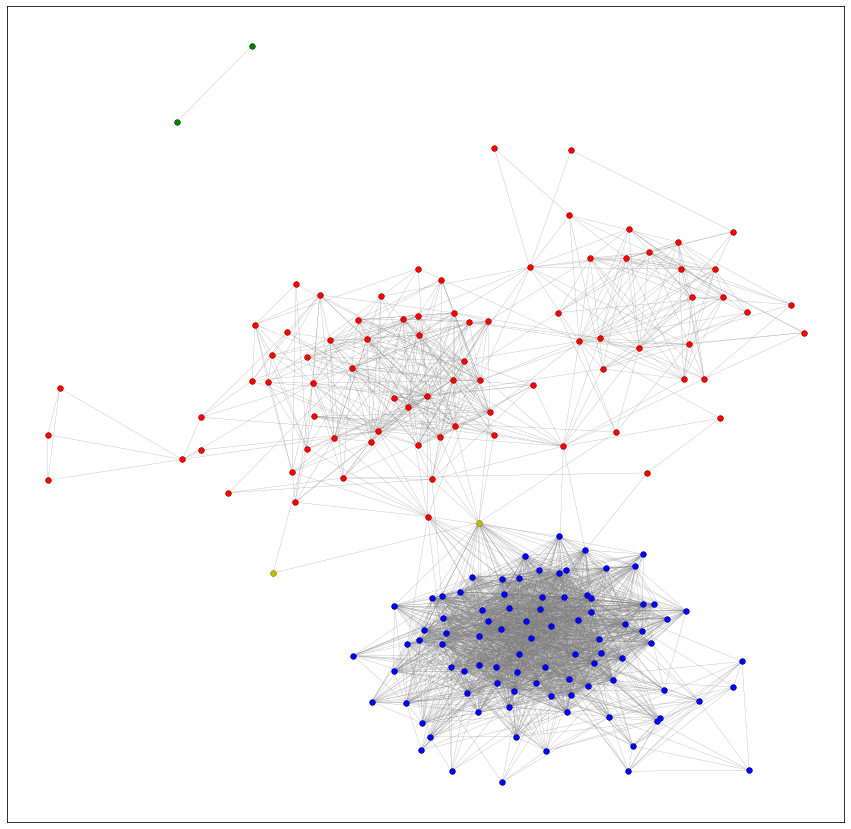

In [105]:
# drawing the network with communities
layout = nx.nx_pydot.graphviz_layout(g)
plt.figure(figsize = (15, 15))
nx.draw_networkx(g, pos = layout, node_size = 25, width = 0.2, node_color = 'k', 
                 edge_color = 'tab:gray', with_labels = False, font_size = 6)
colors = ['b', 'r', 'g', 'y']
for i in range(len(comm)):
    nx.draw_networkx_nodes(g, pos = layout, nodelist = list(comm[i]), node_size = 25, node_color = colors[i])
plt.savefig('comm.png', dpi = 300)